## Contents:
* [General overview](#general-overview)
* [Imports and config](#import-config)
* [Data inpsection and preparation](#data-prep)
* [Model training](#model-creation)
* [Model evaluation](#model-evaluation)
* [Further experiments](#further-experiments)

## General overview <a class="anchor" id="general-overview"></a>

Our goal is to create an ML model that can predict with high accuracy the angle at which a boat should be heading, given metadata features such as boat speed, wind speed, attack angle and target angle. Rather than performing a regression to predict the angle directly, we will instead create two models for predicting the cosine and sine, respectively. This notebook is concerned with predicting the cosine of boat's angle.

As a counter-candidate model for linear regression, we will create a (non-linear) regression model using Keras. In addition to this, we will use cosine and sine of the angles involved as features, rather than the angles themselves.

**Important findings** after running the experiments below:
1. Minimizing MSE is a better strategy than minimizing MAE;
2. Non-linear regression outperforms linear regression;
3. Wider models outperform deeper models. This is not immediately obvious, but seems to be the case in regression tasks involving other well-known datasets, see for example [here](https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)
4. The best model is either 2-hidden layers of sizes (256, 128) OR 2-hidden layers of sizes (512, 256).

## Basic imports <a class="anchor" id="import-config"></a>

In [1]:
import pandas as pd
import numpy as np
import io
import time
import json
import sagemaker.amazon.common as smac
import os
import boto3
import re
import sagemaker
from os.path import join
from sklearn.model_selection import train_test_split

## Setup the config

In [2]:
ROLE = sagemaker.get_execution_role()
REGION = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix

BUCKET = 'virtual-regatta-ml'
PREFIX = 'non_linear_keras_cosine' # place to upload training files within the bucket
TEST_NAME = 'default'

## Load the data <a class="anchor" id="data-prep"></a>

In [3]:
data = pd.read_csv('../all-in-one.csv')
# This column will be predicted using a classifier
data['cos_attack_angle'] = data['angle_of_attack'].apply(lambda x: np.cos(np.deg2rad(x)))
data['sin_attack_angle'] = data['angle_of_attack'].apply(lambda x: np.sin(np.deg2rad(x)))
data = data.drop(columns=['sin_boat_angle','angle_of_attack'])

# The column to predict has to be in last position
df_reordered = data[['boat_speed','cos_attack_angle', 'sin_attack_angle', 'wind_speed','cos_target_angle', 'sin_target_angle', 'cos_boat_angle']]

print(df_reordered.head())


   boat_speed  cos_attack_angle  sin_attack_angle  wind_speed  \
0     7.73236         -0.558392         -0.829577     9.43467   
1     7.73236         -0.558392         -0.829577     9.43467   
2     7.78952         -0.572786         -0.819705     9.59005   
3     7.81913         -0.572786         -0.819705     9.66396   
4     7.81658         -0.572786         -0.819705     9.65759   

   cos_target_angle  sin_target_angle  cos_boat_angle  
0         -0.554636         -0.832093       -0.498210  
1         -0.564295         -0.825573       -0.498210  
2         -0.577277         -0.816548       -0.512318  
3         -0.592192         -0.805797       -0.521811  
4         -0.607512         -0.794311       -0.526100  


The above output suggests we might have a series of duplicate rows, let's check this first

In [4]:
dup_columns_check = ['boat_speed', 'cos_attack_angle', 'sin_attack_angle', 'wind_speed', 'cos_boat_angle']
dup_boat_angle = df_reordered[df_reordered.duplicated(dup_columns_check, keep=False)]
print(f'Total duplicate rows based on {dup_columns_check}: {len(dup_boat_angle)}')
dup_boat_angle.head(10)

Total duplicate rows based on ['boat_speed', 'cos_attack_angle', 'sin_attack_angle', 'wind_speed', 'cos_boat_angle']: 379


,boat_speed,cos_attack_angle,sin_attack_angle,wind_speed,cos_target_angle,sin_target_angle,cos_boat_angle
0,7.73236,-0.558392,-0.829577,9.43467,-0.554636,-0.832093,-0.498210
1,7.73236,-0.558392,-0.829577,9.43467,-0.564295,-0.825573,-0.498210
53,7.67317,-0.481758,-0.876304,9.45885,-0.599954,-0.800035,-0.565606
54,7.67317,-0.481758,-0.876304,9.45885,-0.611783,-0.791026,-0.565606
159,4.99455,0.677019,-0.735966,3.36962,0.246974,-0.969022,0.291625
160,4.99455,0.677019,-0.735966,3.36962,0.248787,-0.968558,0.291625
182,6.71103,-0.094576,-0.995518,3.61274,-0.201650,-0.979458,-0.299201
183,6.71103,-0.094576,-0.995518,3.61274,-0.199921,-0.979812,-0.299201
194,5.73604,-0.765839,-0.643032,4.55132,-0.500285,-0.865861,-0.301758
195,5.73604,-0.765839,-0.643032,4.55132,-0.502534,-0.864557,-0.301758


In [5]:
corr = df_reordered.corr()
corr.style.background_gradient()

,boat_speed,cos_attack_angle,sin_attack_angle,wind_speed,cos_target_angle,sin_target_angle,cos_boat_angle
boat_speed,1.000000,-0.169869,0.372060,0.749770,-0.124149,0.132518,-0.228734
cos_attack_angle,-0.169869,1.000000,0.006623,-0.068656,0.684405,-0.215598,0.709679
sin_attack_angle,0.372060,0.006623,1.000000,0.474577,0.070566,0.223785,-0.068226
wind_speed,0.749770,-0.068656,0.474577,1.000000,-0.024937,0.574937,-0.128242
cos_target_angle,-0.124149,0.684405,0.070566,-0.024937,1.000000,-0.012991,0.925472
sin_target_angle,0.132518,-0.215598,0.223785,0.574937,-0.012991,1.000000,-0.061715
cos_boat_angle,-0.228734,0.709679,-0.068226,-0.128242,0.925472,-0.061715,1.000000


Let's remove duplicates and then have an overview of remaining data

In [6]:
df_reordered = df_reordered.drop_duplicates(subset=dup_columns_check)

In [7]:
df_reordered.describe()

,boat_speed,cos_attack_angle,sin_attack_angle,wind_speed,cos_target_angle,sin_target_angle,cos_boat_angle
count,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000
mean,6.435845,-0.198043,0.058539,8.401832,-0.244525,-0.068352,-0.276057
std,2.747382,0.559119,0.803129,5.182322,0.619872,0.742675,0.595560
min,0.000000,-0.999884,-1.000000,2.000000,-1.000000,-0.999996,-1.000000
25%,4.396755,-0.701373,-0.762417,4.625820,-0.849687,-0.793188,-0.770911
50%,5.818855,-0.302591,0.514912,6.735055,-0.311420,-0.267974,-0.453952
75%,7.868065,0.200625,0.817129,9.959260,0.193021,0.824016,0.173648
max,14.291300,0.999766,1.000000,21.077130,0.999749,0.999990,0.993901


## Create train-val-test split

In [8]:
def save_train_and_validation_data_to_s3(data) :
    test_col = 'cos_boat_angle'
    y_data = data[test_col]
    X_data = data.drop(columns=[test_col])
    X_data = X_data.to_numpy()
    y_data = y_data.to_numpy()
    
    # 70% training, 15% validation, 15% testing split
    train_X, test_X, train_y, test_y = train_test_split(X_data, y_data, train_size=0.7, random_state=42)
    
    val_X, test_X, val_y, test_y = train_test_split(test_X, test_y, train_size=0.5, random_state=41)

    train_file = 'non_linear_train.data'

    f = io.BytesIO()
    smac.write_numpy_to_dense_tensor(f, train_X.astype('float32'), train_y.astype('float32'))
    f.seek(0)
    boto3.Session().resource('s3').Bucket(BUCKET).Object(os.path.join(PREFIX, TEST_NAME, 'train', train_file)).upload_fileobj(f)
    validation_file = 'non_linear_validation.data'
    
    f = io.BytesIO()
    smac.write_numpy_to_dense_tensor(f, val_X.astype('float32'), val_y.astype('float32'))
    f.seek(0)
    boto3.Session().resource('s3').Bucket(BUCKET).Object(os.path.join(PREFIX, TEST_NAME,'validation', validation_file)).upload_fileobj(f)
    return train_X, train_y, val_X, val_y, test_X, test_y

## Create a non-linear regression model using keras <a class="anchor" id="model-creation"></a>

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout


# Build the model
def wide_keras_model(size_1, size_2):
    model = Sequential()
    model.add(Dense(size_1, input_dim=6, kernel_initializer='normal', bias_initializer='normal', activation='relu', name='hidden_1'))
    model.add(Dropout(0.5, seed=42))
    model.add(Dense(size_2, kernel_initializer='normal', bias_initializer='normal', activation='relu', name='hidden_2'))
    model.add(Dropout(0.5, seed=42))
    model.add(Dense(1, kernel_initializer='normal', bias_initializer='normal', activation='linear'))

    # Compile the model
    model.compile(loss="mean_squared_error",
                  metrics=[tf.keras.metrics.MeanAbsoluteError()],
                  optimizer='adam')
    return model

In [10]:
train_X, train_y, val_X, val_y, test_X, test_y = save_train_and_validation_data_to_s3(df_reordered)
train_y = np.expand_dims(train_y, axis=1)
val_y = np.expand_dims(val_y, axis=1)
test_y = np.expand_dims(test_y, axis=1)
print(f'Number of examples in training data: {len(train_y)}')
print(f'Number of examples in validation data: {len(val_y)}')
print(f'Number of examples in test data: {len(test_y)}')

Number of examples in training data: 2405
Number of examples in validation data: 515
Number of examples in test data: 516


### Use a manual grid search for best architecture using Validation data and EarlyStopping

In [11]:
hidden_layer_sizes = [(64, 32), (128, 64), (256, 128), (512, 256)]
models = []
scores = []
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15, 
    restore_best_weights=True,
    verbose=0)

for i, (size_1, size_2) in enumerate(hidden_layer_sizes):
    models.append(wide_keras_model(size_1, size_2))
    models[i].fit(
        train_X,
        train_y,
        epochs=200,
        batch_size=16,
        verbose=0,
        validation_data=(val_X, val_y),
        callbacks=[callback])
    training_score = models[i].evaluate(train_X, train_y, verbose=0)
    val_score = models[i].evaluate(val_X, val_y, verbose=0)
    scores.append(val_score[0])
    print(f'Scores for hidden layer sizes {size_1} and {size_2}:')
    print(f'training MAE:{training_score[1]:.4f}, MSE:{training_score[0]:.4f}')
    print(f'validation MAE:{val_score[1]:.4f}, MSE:{val_score[0]:.4f}')
    print('\n')

Scores for hidden layer sizes 64 and 32:
training MAE:0.0834, MSE:0.0203
validation MAE:0.0855, MSE:0.0237


Scores for hidden layer sizes 128 and 64:
training MAE:0.0746, MSE:0.0147
validation MAE:0.0788, MSE:0.0177


Scores for hidden layer sizes 256 and 128:
training MAE:0.0660, MSE:0.0107
validation MAE:0.0680, MSE:0.0137


Scores for hidden layer sizes 512 and 256:
training MAE:0.0635, MSE:0.0107
validation MAE:0.0694, MSE:0.0146




## Evaluate best model on test data <a class="anchor" id="model-evaluation"></a>

In [12]:
best_idx = np.argmin(scores)
best_sizes = hidden_layer_sizes[best_idx]
best_model = models[best_idx]
best_model.summary()
test_score = best_model.evaluate(test_X, test_y, verbose=0)
print(f'Best performing model is of sizes {best_sizes} for hidden layers')
print(f'Best model MAE on the test set: {test_score[1]:.4f}')
print(f'Best model MSE on the test set: {test_score[0]:.4f}')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 256)               1792      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_2 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 34,817
Trainable params: 34,817
Non-trainable params: 0
_________________________________________________________________
Best performing model is of sizes (256, 128) for hidden layers
Best model MAE on the test set: 0.0712
Best model MSE

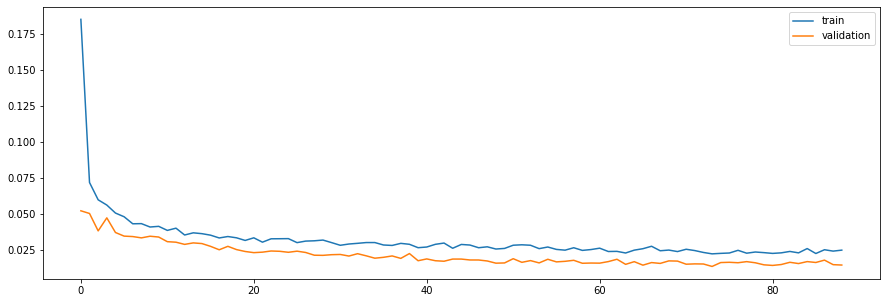

In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(best_model.history.history['loss'], label='train')
plt.plot(best_model.history.history['val_loss'], label='validation')
plt.legend()
plt.show()

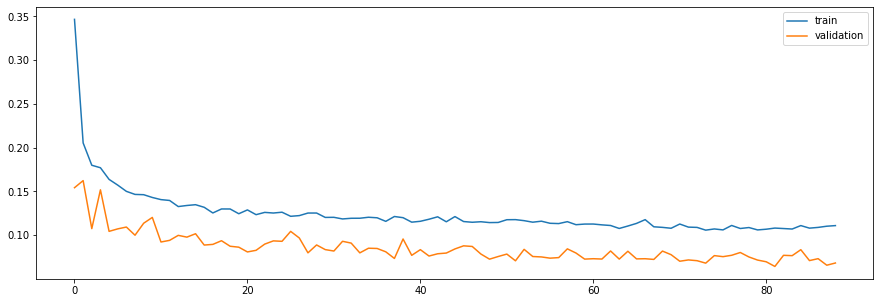

In [14]:
plt.figure(figsize=(15,5))
plt.plot(best_model.history.history['mean_absolute_error'], label='train')
plt.plot(best_model.history.history['val_mean_absolute_error'], label='validation')
plt.legend()
plt.show()

### Sanity check using different library

In [15]:
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde

test_pred = best_model.predict(test_X)
absolute_error = np.squeeze(np.absolute(test_pred - test_y))
print(f'TEST MAE: {np.mean(absolute_error):.4f}')
mse = mean_squared_error(test_y, test_pred)
print(f"Test MSE: {round(mse,4)}, \n")

abs_error = [(-e, i) for i, e in enumerate(absolute_error)]
abs_error.sort()
highest_errors = [
    f'{round(-e,3)}: ({test_pred[i][0]:.3f}, {round(test_y[i][0], 3)})' for e, i in abs_error]
print(f'Top highest absolute value errors on test data: \n {highest_errors[:10]} \n')
print(f'Top lowest absolute value errors on test data: \n {highest_errors[-10:]}')


TEST MAE: 0.0712
Test MSE: 0.0151, 

Top highest absolute value errors on test data: 
 ['1.234: (0.491, -0.743)', '0.744: (-0.459, 0.285)', '0.626: (-0.413, 0.213)', '0.569: (0.389, 0.958)', '0.546: (-0.426, 0.12)', '0.388: (0.569, 0.956)', '0.345: (0.297, -0.048)', '0.338: (0.628, 0.966)', '0.329: (-0.042, 0.287)', '0.323: (-0.420, -0.744)'] 

Top lowest absolute value errors on test data: 
 ['0.002: (-0.529, -0.528)', '0.002: (-0.973, -0.974)', '0.002: (-0.480, -0.479)', '0.001: (0.060, 0.061)', '0.001: (-0.575, -0.574)', '0.001: (0.048, 0.049)', '0.001: (-0.723, -0.722)', '0.001: (-0.483, -0.483)', '0.001: (0.033, 0.034)', '0.0: (-0.481, -0.481)']


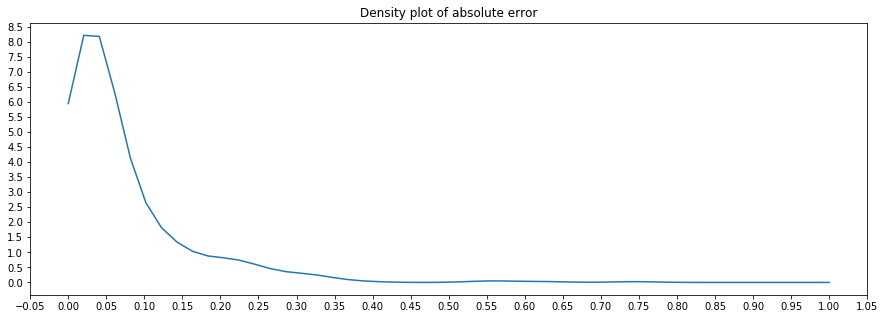

In [16]:
density = gaussian_kde(absolute_error)
xs = np.linspace(0,1,50)
plt.figure(figsize=(15,5))
plt.plot(xs,density(xs))
plt.locator_params(axis='y', nbins=20)
plt.locator_params(axis='x', nbins=30)
plt.title('Density plot of absolute error')
plt.show()

## Save the best model to bucket

In [32]:
from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

version_number = '2'
export_dir = 'export/Servo/' + version_number
builder = builder.SavedModelBuilder(export_dir)
signature = predict_signature_def(
    inputs={"inputs": best_model.input}, outputs={"score": best_model.output})
from keras import backend as K
with K.get_session() as sess:
    builder.add_meta_graph_and_variables(
        sess=sess, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
    builder.save()


RuntimeError: build_tensor_info is not supported in Eager mode.

In [18]:
MODEL_h5_NAME = 'keras-cosine-model.h5'
MODEL_tar_NAME = "keras-cosine-model.tar.gz"
MODEL_BUCKET_PATH = os.path.join('keras_models', MODEL_tar_NAME)

In [19]:
best_model.save(MODEL_h5_NAME)

import tarfile
tar = tarfile.open(MODEL_tar_NAME, "w:gz")
tar.add(MODEL_h5_NAME)
tar.close()

In [20]:
client = boto3.client('s3')
client.upload_file(Filename=MODEL_tar_NAME,
                  Bucket=BUCKET,
                  Key=MODEL_BUCKET_PATH)


In [21]:
!touch train.py

In [29]:
from sagemaker.tensorflow import TensorFlowModel
model = TensorFlowModel(
    model_data='s3://' + BUCKET + '/' + MODEL_BUCKET_PATH,
    role=ROLE,
    py_version='py3',
    entry_point='train.py',
    framework_version="2.1.0")
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
2.1.0 is the latest version of tensorflow that supports Python 2. Newer versions of tensorflow will only be available for Python 3.Please set the argument "py_version='py3'" to use the Python 3 tensorflow image.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-*

UnexpectedStatusException: Error hosting endpoint sagemaker-tensorflow-2020-10-15-13-31-26-291: Failed. Reason:  The image '520713654638.dkr.ecr.eu-west-2.amazonaws.com/sagemaker-tensorflow:2.1.0-cpu-py2' does not exist..

In [ ]:
# stop here when running all cells
assert False

## Further experiments <a class="anchor" id="further-experiments"></a>

Try linear regression with keras

In [ ]:
def linear_keras():
    model = Sequential()
    model.add(Dense(8, kernel_initializer='normal', activation='linear', name='hidden_1'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))

    # Compile the model
    model.compile(loss="mean_squared_error",
                  metrics=[tf.keras.metrics.MeanAbsoluteError()],
                  optimizer='adam')
    return model

In [ ]:

models = []
scores = []
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15, 
    restore_best_weights=True,
    verbose=0)

models.append(linear_keras())
models[0].fit(
    train_X,
    train_y,
    epochs=200,
    batch_size=32,
    verbose=0,
    validation_data=(val_X, val_y),
    callbacks=[callback])
training_score = models[0].evaluate(train_X, train_y, verbose=0)
val_score = models[0].evaluate(val_X, val_y, verbose=0)
scores.append(val_score[0])
print(f'training MAE:{training_score[1]:.4f}, MSE:{training_score[0]:.4f}')
print(f'validation MAE:{val_score[1]:.4f}, MSE:{val_score[0]:.4f}')
print('\n')

Try one layer keras model

In [ ]:
# Build the model
def wider_keras_model(size):
    model = Sequential()
    model.add(Dense(size_1, kernel_initializer='normal', activation='relu', name='hidden_1'))
    model.add(Dropout(0.5, seed=42))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))

    # Compile the model
    model.compile(loss="mean_squared_error",
                  metrics=[tf.keras.metrics.MeanAbsoluteError()],
                  optimizer='adam')
    return model

In [ ]:
hidden_layer_sizes = [8, 16, 32, 64, 128, 512]
models = []
scores = []
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15, 
    restore_best_weights=True,
    verbose=0)

for i, size in enumerate(hidden_layer_sizes):
    models.append(wider_keras_model(size))
    models[i].fit(
        train_X,
        train_y,
        epochs=200,
        batch_size=32,
        verbose=0,
        validation_data=(val_X, val_y),
        callbacks=[callback])
    training_score = models[i].evaluate(train_X, train_y, verbose=0)
    val_score = models[i].evaluate(val_X, val_y, verbose=0)
    scores.append(val_score[0])
    print(f'Scores for hidden layer size {size}:')
    print(f'training MAE:{training_score[1]:.4f}, MSE:{training_score[0]:.4f}')
    print(f'validation MAE:{val_score[1]:.4f}, MSE:{val_score[0]:.4f}')
    print('\n')

### Check what happens if we minimize for MAE instead

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout


# Build the model
def wide_keras_model(size_1, size_2):
    model = Sequential()
    model.add(Dense(size_1, kernel_initializer='normal', activation='relu', name='hidden_1'))
    model.add(Dropout(0.5, seed=42))
    model.add(Dense(size_2, kernel_initializer='normal', activation='relu', name='hidden_2'))
    model.add(Dropout(0.5, seed=42))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))

    # Compile the model
    model.compile(loss="mean_absolute_error",
                  metrics=[tf.keras.metrics.MeanSquaredError()],
                  optimizer='adam')
    return model

In [ ]:
train_X, train_y, val_X, val_y, test_X, test_y = save_train_and_validation_data_to_s3(df_reordered)
train_y = np.expand_dims(train_y, axis=1)
val_y = np.expand_dims(val_y, axis=1)
test_y = np.expand_dims(test_y, axis=1)
print(f'Number of examples in training data: {len(train_y)}')
print(f'Number of examples in validation data: {len(val_y)}')
print(f'Number of examples in test data: {len(test_y)}')

In [ ]:
hidden_layer_sizes = [(32, 16), (64, 32), (128, 64), (256, 128), (512, 256)]
models = []
scores = []
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True,
    verbose=0)

for i, (size_1, size_2) in enumerate(hidden_layer_sizes):
    models.append(wide_keras_model(size_1, size_2))
    models[i].fit(
        train_X,
        train_y,
        epochs=100,
        batch_size=16,
        verbose=0,
        validation_data=(val_X, val_y),
        callbacks=[callback])
    training_score = models[i].evaluate(train_X, train_y, verbose=0)
    val_score = models[i].evaluate(val_X, val_y, verbose=0)
    scores.append(val_score[0])
    print(f'Scores for hidden layer sizes {size_1} and {size_2}:')
    print(f'training MAE:{training_score[0]:.4f}, MSE:{training_score[1]:.4f}')
    print(f'validation MAE:{val_score[0]:.4f}, MSE:{val_score[1]:.4f}')
    print('\n')

In [ ]:
best_idx = np.argmin(scores)
best_sizes = hidden_layer_sizes[best_idx]
best_model = models[best_idx]
test_score = best_model.evaluate(test_X, test_y, verbose=0)
print(f'Best performing model is of sizes {best_sizes} for hidden layers')
print(f'Best model MAE on the test set: {test_score[0]:.4f}')
print(f'Best model MSE on the test set: {test_score[1]:.4f}')


In [ ]:
from matplotlib import pyplot as plt

plt.plot(best_model.history.history['loss'], label='train')
plt.plot(best_model.history.history['val_loss'], label='validation')
plt.legend()
plt.show()

Sanity check using a different library

In [ ]:
test_pred = best_model.predict(test_X)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, test_pred)
print("Test MSE:", round(mse,4))

### Try deeper architectures for comparison

In [ ]:
def deep_keras_model(size_first_layer, num_layers):
    model = Sequential()
    size = size_first_layer
    model.add(Dense(size, input_dim=6, kernel_initializer='normal', activation='relu', name='hidden_1'))
    for i in range(1, num_layers):
        size //= 2
        model.add(Dense(size, kernel_initializer='normal', activation='relu', name='hidden' + str(i)))
        model.add(Dropout(0.5, seed=42))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))

    # Compile the model
    model.compile(loss="mean_squared_error",
                  metrics=[tf.keras.metrics.MeanAbsoluteError()],
                  optimizer='adam')
    return model

In [ ]:
deep_sizes = [(16, 3), (16, 4), (32, 5), (64, 6), (128, 7)]
deep_models = []
deep_scores = []
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True,
    verbose=0)

for i, (size_first_layer, num_layers) in enumerate(deep_sizes):
    deep_models.append(deep_keras_model(size_first_layer, num_layers))
    deep_models[i].fit(
        train_X,
        train_y,
        epochs=200,
        batch_size=16,
        verbose=0,
        validation_data=(val_X, val_y),
        callbacks=[callback])
    training_score = deep_models[i].evaluate(train_X, train_y, verbose=0)
    val_score = deep_models[i].evaluate(val_X, val_y, verbose=0)
    deep_scores.append(val_score[0])
    print(f'Scores for {num_layers} hidden layers with first layer of size {size_first_layer}:')
    print(f'training MAE:{training_score[1]:.4f}, MSE:{training_score[0]:.4f}')
    print(f'validation MAE:{val_score[1]:.4f}, MSE:{val_score[0]:.4f}')
    print('\n')

In [ ]:
best_deep_idx = np.argmin(deep_scores)
best_sizes = deep_sizes[best_deep_idx]
best_deep_model = deep_models[best_deep_idx]
test_score = best_deep_model.evaluate(test_X, test_y, verbose=0)
print(f'Best performing model is of sizes {best_sizes} for hidden layers')
print(f'Best model MAE on the test set: {test_score[0]:.4f}')
print(f'Best model MSE on the test set: {test_score[1]:.4f}')

## Load the SageMaker Tensorflow training

In [ ]:
# from sagemaker.tensorflow import Tensorflow

# tf_estimator = TensorFlow(
#     entry_point='non_linear_keras_train.py',
#     train_instance_count=1,
#     train_instance_type="ml.m5.large",
#     famework_version=tf_version,
#     py_version='py3',
#     script_mode=True,
#     hyperparameters={
#         'epochs': 10,
#         'batch_size': 32,
#     })